2D Bi-Gaussian Mixture Model (GMM) is expected to have better performance compared to Principal Component Analysis, due to the physical nature of the process.

Here, we predict 12 parameters which generates Bi-Gaussian distribution on the LPS image, rather than the full image.

In [1]:
# Autoload when refreshing notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
from scipy.optimize import curve_fit

# import Python functions 
import sys
sys.path.append('../../')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN, extract_processed_images, apply_centroid_correction,apply_tcav_zeroing_filter, MLP
from Python_Functions.gmm import biGaussian_image_from_flattened_params, flatten_biGaussian_params, unflatten_biGaussian_params, gaussian_2d_pdf, is_valid_biGaussian_params, image_to_bigaussian_params, GeometricScaler

### Load Preprocessed Images

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from scipy.io import loadmat 
import re
import os 
# Assumed: commonIndexFromSteps, extractDAQBSAScalars, and other helper functions are available

# ----------------------------------------------------------------------
# 1. Define the list of (experiment, runname, step_identifier) pairs to load
# ----------------------------------------------------------------------
run_pairs = [
    ('E338', '12710', 1),  # Example pairs, modify this list
    #('E300', '12431', 1),
    #('E338', '12710', 1)
    # Add more pairs here...
]

# ----------------------------------------------------------------------
# 2. Initialize lists for concatenation
# ----------------------------------------------------------------------
all_images = []
all_predictors = []
all_indices = []

print("Starting multi-run data loading and concatenation...")

# ----------------------------------------------------------------------
# 3. Loop through runs, load data, and concatenate
# ----------------------------------------------------------------------
for experiment, runname, step_id in run_pairs:
    
    # --- A. Load Processed LPSImage Data and Good Shots Index ---
    pickle_filename = f'../../data/processed/LPSImage_goodshots_{experiment}_{runname}_{step_id}.pkl'

    try:
        with open(pickle_filename, 'rb') as f:
            data = pickle.load(f)
        
        LPSImage_good = data['LPSImage'] # Filtered LPS images
        # This 'goodShots' index is relative to the phase-filtered data (all_idx).
        goodShots_scal_common_index = data['scalarCommonIndex'] 
        
        print(f"Loaded {experiment}_{runname}: LPSImage shape {LPSImage_good.shape}")
        
    except FileNotFoundError:
        print(f"Skipping {experiment}_{runname}: Pickle file not found at {pickle_filename}")
        continue
    
    # --- B. Load and Filter Predictor Data (BSA Scalars) ---
    
    # 1. Load data_struct
    dataloc = f'../../data/raw/{experiment}/{experiment}_{runname}/{experiment}_{runname}.mat'
    try:
        mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
        data_struct = mat['data_struct']
    except FileNotFoundError:
        print(f"Skipping {experiment}_{runname}: .mat file not found at {dataloc}")
        continue

    # 2. Extract full BSA scalars (filtered by step_list if needed)
    # Don't filter by common index here, we'll do it with the goodShots scalar common index loaded from the file
    bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct, filter_index=False)
    bsaScalarData = apply_tcav_zeroing_filter(bsaScalarData, bsaVars)

    # 3. 

    # 5. Filter BSA data using the final index
    # goodShots_scal_common_index is 1 based indexing from MATLAB, convert to 0 based
    bsaScalarData_filtered = bsaScalarData[:, goodShots_scal_common_index - 1]
    
    # 6. Construct the predictor array
    predictor_current = np.vstack(bsaScalarData_filtered).T
    
    # C. Append to master lists
    all_images.append(LPSImage_good)
    all_predictors.append(predictor_current)
    
# ----------------------------------------------------------------------
# 4. Concatenate and finalize arrays
# ----------------------------------------------------------------------

# Set image half dimensions (should match preprocessing)
yrange = 50
xrange = 150

# Combine all data arrays from the runs
images_tmp = np.concatenate(all_images, axis=0)
images_tmp = images_tmp.reshape(images_tmp.shape[0], 2*yrange, 2* xrange)  # Reshape to (N, height, width)
predictor_tmp = np.concatenate(all_predictors, axis=0)


print("\n--- Final Concatenated Data Shapes ---")
print(f"Total LPS Images (images): {images_tmp.shape}")
print(f"Total Predictors (predictor): {predictor_tmp.shape}")


Starting multi-run data loading and concatenation...
Loaded E338_12710: LPSImage shape (1382, 30000)
Applying filter: Setting 1086 samples of TCAV_LI20_2400_P to 0 where TCAV_LI20_2400_A < 1.0

--- Final Concatenated Data Shapes ---
Total LPS Images (images): (1382, 100, 300)
Total Predictors (predictor): (1382, 130)


### Phase selection, flip images

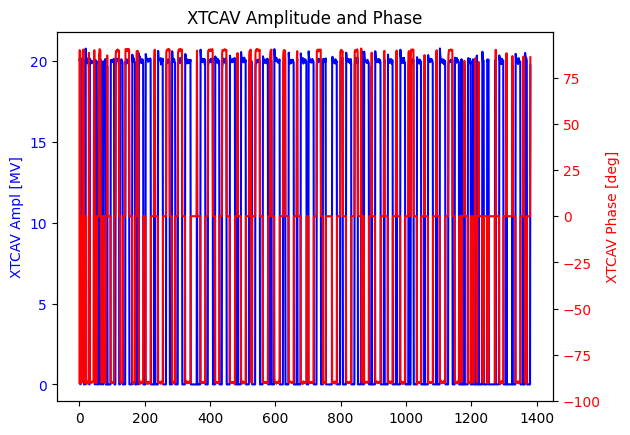

In [3]:
ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = predictor_tmp[:, ampl_idx]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = predictor_tmp[:, phase_idx]
xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting
# 
near_minus_90_idx = np.where((xtcavPhase >= -90.55) & (xtcavPhase <= -89.55))[0]
near_plus_90_idx = np.where((xtcavPhase >= 89.55) & (xtcavPhase <= 90.55))[0]
lps_idx = near_minus_90_idx.tolist() + near_plus_90_idx.tolist()
# Flip image horizontally for -90 deg phase
images_flipped = images_tmp.copy()
images_flipped[near_minus_90_idx, :, :] = np.flip(images_tmp[near_minus_90_idx, :, :], axis=2)

fig, ax1 = plt.subplots()
ax1.plot(xtcavAmpl, label='Amplitude', color='b')
ax1.set_ylabel('XTCAV Ampl [MV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(xtcavPhase, label='Phase', color='r')
ax2.set_ylabel('XTCAV Phase [deg]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('XTCAV Amplitude and Phase')
plt.show()

### Exclude BSA Variables

In [4]:
from Python_Functions.functions import exclude_bsa_vars
excluded_var_idx = exclude_bsa_vars(bsaVars)
predictor_tmp_cleaned = np.delete(predictor_tmp, excluded_var_idx, axis=1)[lps_idx, :]
print(f"Predictor shape after excluding variables: {predictor_tmp_cleaned.shape}")

LPSimg = images_flipped[lps_idx]
print(f"LPS Image shape after filtering: {LPSimg.shape}")


Excluding BSA Variables: ['TCAV_LI20_2400_A', 'TCAV_LI20_2400_P', 'TORO_LI20_3163_TMIT', 'TORO_LI20_3255_TMIT', 'BPMS_LI20_3156_X', 'BPMS_LI20_3156_Y', 'BPMS_LI20_3156_TMIT', 'BPMS_LI20_3218_X', 'BPMS_LI20_3218_Y', 'BPMS_LI20_3218_TMIT', 'BPMS_LI20_3265_X', 'BPMS_LI20_3265_Y', 'BPMS_LI20_3265_TMIT', 'BPMS_LI20_3315_X', 'BPMS_LI20_3315_Y', 'BPMS_LI20_3315_TMIT', 'PMT_LI20_3179_QDCRAW', 'PMT_LI20_3350_QDCRAW', 'PMT_LI20_3360_QDCRAW', 'WIRE_LI20_3179_POSN']
Excluded variable indices: [104, 105, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 129]
Predictor shape after excluding variables: (554, 110)
LPS Image shape after filtering: (554, 100, 300)


### Calibration

In [5]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
if isChargePV:
    # Extract charge data
    pvidx = [i for i, val in enumerate(isChargePV) if val]
    charge = bsaScalarData[pvidx, :][0] * 1.6e-19  # in C 
    charge_filtered = charge[goodShots_scal_common_index - 1][lps_idx]
# Flags
# If enabled, GMM fit is weighted to predict better current profile rather than overall image fit
do_current_profile = True
NCOMP = 10

In [6]:
print(data_struct.scalars.nonBSA_List_S20Magnets.LI20_XCOR_3086_BACT)

[0.03354445 0.03354445 0.03354445 ... 0.03354104 0.03354104 0.03354104]


### Bi-Gaussian Fit

In [7]:
from ipywidgets import interact
def interactive_biGaussian_fit_example(idx):
    biGaussianTest = image_to_bigaussian_params(LPSimg[idx], do_current_profile)
    print("Bi-Gaussian Parameters for Test Image:", biGaussianTest)
    generated_image = biGaussian_image_from_flattened_params(flatten_biGaussian_params(biGaussianTest), total_charge=charge_filtered[idx] if isChargePV else None, xrange=xrange, yrange=yrange)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(LPSimg[idx], cmap='hot', origin='lower')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title("Generated from Bi-Gaussian Fit")
    plt.imshow(generated_image.T, cmap='hot', origin='lower')
    plt.colorbar()
    plt.show()
interact(interactive_biGaussian_fit_example, idx=(0, LPSimg.shape[0]-1, 1))

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

<function __main__.interactive_biGaussian_fit_example(idx)>

In [8]:
# Convert all images to bi-Gaussian parameters
biGaussian_params_list = []
print(LPSimg.shape)
success_count = 0
for i in range(LPSimg.shape[0]):
    try:
        biGaussian_params = image_to_bigaussian_params(LPSimg[i], do_current_profile, debug=False)
        #print(f"Processed image {i+1}/{images.shape[0]}: Bi-Gaussian params: {biGaussian_params}")
        flattened_params = flatten_biGaussian_params(biGaussian_params)
        biGaussian_params_list.append(flattened_params)
        success_count += 1
    except Exception as e:
        print(f"Error processing image {i}: {e}")
        flattened_params = np.full((NCOMP,), np.nan)  # Assuming 10 parameters for 2-component bi-Gaussian
        biGaussian_params_list.append(flattened_params)

biGaussian_params_array = np.array(biGaussian_params_list)
print("Converted all images to Bi-Gaussian parameters with shape:", biGaussian_params_array.shape)
print(f"Successfully processed {success_count}/{LPSimg.shape[0]} images into Bi-Gaussian parameters.")
# Pickle and save the bi-Gaussian parameters for future use
import time
timestamp = time.strftime("%Y%m%d_%H%M%S")
output_pickle_filename = f'../../data/processed/LPSImage_biGaussian_params_{experiment}_{runname}_{timestamp}.pkl'
with open(output_pickle_filename, 'wb') as f:
    pickle.dump({'biGaussian_params': biGaussian_params_array}, f)
print(f"Saved Bi-Gaussian parameters to {output_pickle_filename}")

(554, 100, 300)
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. Retaining original estimates.
Current profile fitting failed for component 2. 

### Random Forest Regression

In [ ]:
# Filter rows with NaN or invalid bi-Gaussian parameters
valid_rows = [ is_valid_biGaussian_params(biGaussian_params_array[i], do_current_profile) for i in range(biGaussian_params_array.shape[0]) ]
predictor_filtered = predictor_tmp_cleaned[valid_rows]
biGaussian_params_array_filtered = biGaussian_params_array[valid_rows]
print(f"After removing invalid rows, dataset shape: Predictors {predictor_filtered.shape}, Bi-Gaussian Params {biGaussian_params_array_filtered.shape}")

# --- Original scaling and splitting logic follows ---

x_scaler = MinMaxScaler()
iz_scaler = GeometricScaler(xrange, yrange)
x_scaled = x_scaler.fit_transform(predictor_filtered)
Iz_scaled = iz_scaler.fit_transform(biGaussian_params_array_filtered)



# 80/20 train-test split
x_train_full, x_test_scaled, Iz_train_full, Iz_test_scaled, ntrain, ntest = train_test_split(
    x_scaled, Iz_scaled, np.arange(Iz_scaled.shape[0]), test_size=0.2, random_state = 42)

# 20% validation split 
x_train_scaled, x_validation, Iz_train_scaled, y_validation = train_test_split(
    x_train_full, Iz_train_full, test_size=0.2, random_state = 42)

# Convert to PyTorch tensors
X_train = torch.tensor(x_train_scaled, dtype=torch.float32)
x_validation = torch.tensor(x_validation, dtype=torch.float32)
X_test = torch.tensor(x_test_scaled, dtype=torch.float32)
Y_train = torch.tensor(Iz_train_scaled, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)
Y_test = torch.tensor(Iz_test_scaled, dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=24, shuffle=True)

After removing invalid rows, dataset shape: Predictors (551, 110), Bi-Gaussian Params (551, 10)


In [10]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

# --- 2. Model and Hyperparameter Setup ---
# The Random Forest is initialized with its structure (number of trees, depth, etc.)
# This replaces the PyTorch MLP class definition.

print("\n--- Initializing Model ---")
# Equivalent to: model = MLP(X_train.shape[1], Y_train.shape[1])
# n_estimators is equivalent to the overall model complexity/capacity
# max_depth controls the depth, similar to the number of layers/nodes.
model = RandomForestRegressor(
    n_estimators=500,        # Number of trees (like epochs/steps, higher = more complex)
    max_depth=15,            # Max depth of trees (limits complexity)
    min_samples_leaf=5,      # Regularization/pruning parameter
    random_state=42,
    n_jobs=-1                # Use all available cores
)

# Note: In Random Forest, there is no separate 'optimizer' or 'learning rate'
# as the training is done via deterministic tree growing (not gradient descent).


# --- 4. Training and Evaluation (Equivalent to the Training Loop) ---
# Random Forest is trained in a single 'fit' call, not in epochs.
# We mimic the training block structure and calculate loss/metrics.

t0 = time.time()
print("\n--- Starting Model Fitting (One Shot) ---")

# Fit the model (This is the entire 'training loop' for RF)
model.fit(X_train, Y_train)

t1 = time.time()

# --- Evaluation ---

# 1. Training Set Evaluation
Y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(Y_train, Y_train_pred)

# 2. Validation Set Evaluation
Y_val_pred = model.predict(x_validation)
val_mse = mean_squared_error(y_validation, Y_val_pred)


print("\n--- Training Results ---")
print(f"Total Fitting Time: {t1 - t0:.2f} seconds")
print(f"Final Train MSE: {train_mse:.6f}")
print(f"Final Validation MSE: {val_mse:.6f}")

# To see the importance of the input features:
print("\n--- Feature Importance ---")
for i, importance in enumerate(model.feature_importances_):
    print(f"Feature {i} importance: {importance:.4f}")


X_train shape: torch.Size([352, 110])
Y_train shape: torch.Size([352, 10])

--- Initializing Model ---

--- Starting Model Fitting (One Shot) ---

--- Training Results ---
Total Fitting Time: 0.54 seconds
Final Train MSE: 0.003152
Final Validation MSE: 0.006711

--- Feature Importance ---
Feature 0 importance: 0.0002
Feature 1 importance: 0.0005
Feature 2 importance: 0.0004
Feature 3 importance: 0.0025
Feature 4 importance: 0.0068
Feature 5 importance: 0.0001
Feature 6 importance: 0.0037
Feature 7 importance: 0.0043
Feature 8 importance: 0.0000
Feature 9 importance: 0.0129
Feature 10 importance: 0.0018
Feature 11 importance: 0.0003
Feature 12 importance: 0.0013
Feature 13 importance: 0.0031
Feature 14 importance: 0.0003
Feature 15 importance: 0.0018
Feature 16 importance: 0.0038
Feature 17 importance: 0.0001
Feature 18 importance: 0.0022
Feature 19 importance: 0.0038
Feature 20 importance: 0.0002
Feature 21 importance: 0.0055
Feature 22 importance: 0.0035
Feature 23 importance: 0.0001


Elapsed time [mins] = 0.0 
Train R²: 97.76 %
Test R²: 96.32 %


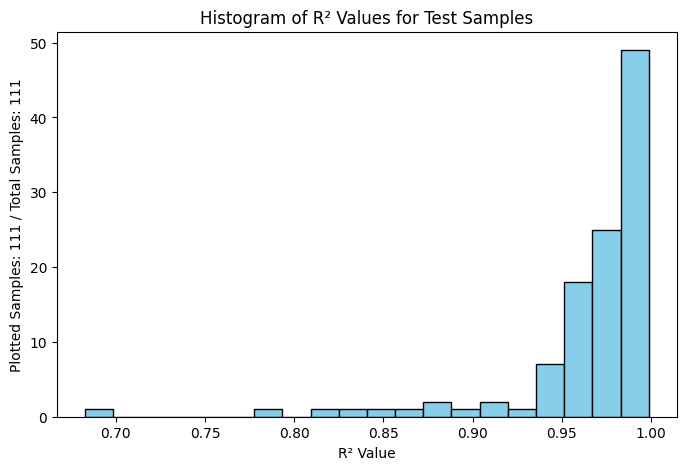

In [11]:
    
# Evaluate model
pred_train_scaled = model.predict(X_train)
pred_test_scaled = model.predict(X_test)

# Inverse transform predictions
pred_train_full = iz_scaler.inverse_transform(pred_train_scaled)
pred_test_full = iz_scaler.inverse_transform(pred_test_scaled)
Iz_train_true = iz_scaler.inverse_transform(Iz_train_scaled)
Iz_test_true = iz_scaler.inverse_transform(Iz_test_scaled)
elapsed = time.time() - t0
print("Elapsed time [mins] = {:.1f} ".format(elapsed/60))

# Compute R² score
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

# Compute R² on scaled data, instead of the actual bi-Gaussian parameters, to avoid distortion from different scales
print("Train R²: {:.2f} %".format(r2_score(Iz_train_scaled.ravel(), pred_train_scaled.ravel()) * 100))
print("Test R²: {:.2f} %".format(r2_score(Iz_test_scaled.ravel(), pred_test_scaled.ravel()) * 100))

# Plot histogram of R² values for each test sample
r2_values = [r2_score(Iz_test_scaled.T.reshape(NCOMP,Iz_test_scaled.shape[0])[:,i], pred_test_scaled.T.reshape(NCOMP,Iz_test_scaled.shape[0])[:,i]) for i in range(Iz_test_scaled.shape[0])]
# Throw away values outside 0 to 1, and count the number of throws
r2_values_new = [r2 for r2 in r2_values if 0 <= r2 <= 1]
num_throws = len(r2_values) - len(r2_values_new)
plt.figure(figsize=(8, 5))
plt.hist(r2_values_new, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of R² Values for Test Samples')
plt.xlabel('R² Value')
plt.ylabel(f'Plotted Samples: {len(r2_values) - num_throws} / Total Samples: {len(r2_values)}')
plt.show()

In [12]:
idx_tmp = 34
print(pred_test_scaled[idx_tmp])
print(pred_test_full[idx_tmp])
print(Iz_train_scaled[idx_tmp])
print(Iz_train_true[idx_tmp])

[ 2.68283755e-01 -2.68283754e-01 -3.41401149e-01  5.42716687e-01
  1.02027957e-01 -1.83256842e-01  7.61151907e-01  6.08141336e-02
 -6.89212587e-04  1.52605411e-01]
[  0.76828376   0.23171625 -51.21017242  27.13583435 114.781452
 -68.72131576  95.14398837  68.41590033  -0.25845472  19.07567634]
[ 0.31261075 -0.31261075 -0.5169291   0.84        0.06814941 -0.13880886
  0.71896666  0.10839508  0.06903861  0.14334172]
[  0.81261075   0.18738925 -77.53936     42.          76.66808
 -52.05332     89.870834   121.944466    25.88948     17.917715  ]


### Plot true vs prediction

In [ ]:
from ipywidgets import interact, IntSlider, Layout
def plot_xtcav_image_pred(idx):
    FACTOR = 1e15  # to convert s to fs
    fig, (ax0, ax1, ax2, cx1) = plt.subplots(1,4,figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1, 1, 0.02]})

    raw_im = LPSimg[valid_rows][ntest[idx]]
    im0 = ax0.imshow(raw_im, cmap = "jet",aspect='auto',extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))
    ax0.set(ylabel="Energy [pix]")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(title = f"Raw Image (Shot Number: {ntest[idx]})")


    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    true_im = biGaussian_image_from_flattened_params(true_params, total_charge=charge_filtered[ntest[idx]], xrange=xrange, yrange=yrange).T
    im1 = ax1.imshow(true_im*FACTOR, cmap = "jet",aspect='auto',extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))

    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="Energy [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest[idx]})")
    # print("True Gaussian Parameters:")
    # true_ug = unflatten_biGaussian_params(true_params)
    # print("Means (Mu):", true_ug['mu'].numpy())
    # print("Covariances (Sigma):", true_ug['Sigma'].numpy())
    # print("Weights (Pi):", true_ug['pi'].numpy())


    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    pred_im = biGaussian_image_from_flattened_params(pred_params, total_charge=charge_filtered[ntest[idx]], xrange=xrange, yrange=yrange).T
    im2 = ax2.imshow(pred_im*FACTOR, cmap = "jet",aspect='auto', extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "Energy [pix]")
    ax2.set(title = "Prediction")

    print("Predicted Gaussian Parameters:")
    pred_ug = unflatten_biGaussian_params(pred_params)
    print("Means (Mu):", pred_ug['mu'].numpy())
    print("Covariances (Sigma):", pred_ug['Sigma'].numpy())
    print("Weights (Pi):", pred_ug['pi'].numpy())

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    cbar.set_label("Current [A per pixel]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# Create slider
interact(plot_xtcav_image_pred, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0, layout=Layout(width='80%')))

interactive(children=(IntSlider(value=0, description='idx', max=110), Output()), _dom_classes=('widget-interac…

<function __main__.plot_xtcav_image_pred(idx)>

In [39]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image_pred_current(idx):
    FACTOR = 1e15
    fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10, 6))

    x_grid = np.linspace(-xrange*xtcalibrationfactor*FACTOR, xrange*xtcalibrationfactor*FACTOR, xrange * 2)
    raw_im = np.flip(LPSimg[valid_rows][ntest[idx]], axis=0)
    raw_im_proj = np.sum(raw_im, axis = 0)
    print(raw_im_proj.shape)
    raw_im_proj = raw_im_proj / np.sum(raw_im_proj)
    # Measure the peak for translation
    peak_index = np.argmax(raw_im_proj)
    if isChargePV:
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        raw_im_proj = raw_im_proj * charge_value * FACTOR
    ax0.plot(x_grid, raw_im_proj, label = "raw")
    ax0.set(ylabel="Current [A]")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(title = f"Raw Image (Shot Number: {ntest[idx]}) (Total Charge: {charge_value*1e12:.2f} pC)" if isChargePV else f"Raw Image (Shot Number: {ntest[idx]})")

    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    
    if isChargePV:
        # Normalize true image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        true_im = biGaussian_image_from_flattened_params(true_params, charge_value, xrange=xrange, yrange=yrange)
    else:
        true_im = biGaussian_image_from_flattened_params(true_params, xrange=xrange, yrange=yrange)
    true_im = true_im.T
    true_im_proj = np.sum(true_im, axis = 0)  * FACTOR
    ax0.plot(x_grid+(peak_index-xrange) * xtcalibrationfactor * FACTOR, true_im_proj, label = "fit")


    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    # Current profile is relative to zeta; transpose so that the drive bunch center agrees with the fit.
    pred_params_uf = unflatten_biGaussian_params(pred_params)
    true_params_uf = unflatten_biGaussian_params(true_params)
    pred_params_uf['mu'] -= pred_params_uf['mu'][0] - true_params_uf['mu'][0]
    pred_params = flatten_biGaussian_params(pred_params_uf)
    
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im = biGaussian_image_from_flattened_params(pred_params, charge_value, xrange=xrange, yrange=yrange)
    else:
        pred_im = biGaussian_image_from_flattened_params(pred_params, xrange=xrange, yrange=yrange)
    pred_im = pred_im.T
    pred_im_proj = np.sum(pred_im, axis = 0) * FACTOR
    ax0.plot(x_grid+(peak_index-xrange) * xtcalibrationfactor * FACTOR, pred_im_proj, label = "prediction")
    # Fix x-axis limits
    ax0.set(xlim = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR))
    # Log scale y-axis
    ax0.set(yscale='log')
    ax0.set(ylim=(1e2, None))
    ax0.legend()

    ax1.imshow(np.flip(raw_im, axis=0), cmap = "jet",aspect='auto', extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))

    print("Predicted Gaussian Parameters:")
    pred_ug = unflatten_biGaussian_params(pred_params)
    print("Means (Mu):", pred_ug['mu'].numpy())
    ax1.axvline((true_params_uf['mu'].numpy()[1][0]+peak_index - xrange)*xtcalibrationfactor*FACTOR, color='red', linestyle='--', label='True Mu')#
    ax1.axvline((pred_ug['mu'].numpy()[1][0]+peak_index - xrange)*xtcalibrationfactor*FACTOR, color='green', linestyle='--', label='Predicted Mu')#
    print("Covariances (Sigma):", pred_ug['Sigma'].numpy())
    print("Weights (Pi):", pred_ug['pi'].numpy())
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

    # Display image_to_bigaussian_params debug info
    #biGaussianTest = image_to_bigaussian_params(images[valid_rows][ntest[idx]].reshape((2*yrange, 2*xrange)), do_current_profile, debug=True)
    #print("Bi-Gaussian Parameters for Test Image:", biGaussianTest)
    

# Create slider
interact(plot_xtcav_image_pred_current, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0, layout=Layout(width='80%')))

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='80%'), max=110), Output()), _…

<function __main__.plot_xtcav_image_pred_current(idx)>

### PCA of PV Scalars

Plotting BSA Scalars: TCAV_LI20_2400_P (index 127) and TCAV_LI20_2400_A (index 126)


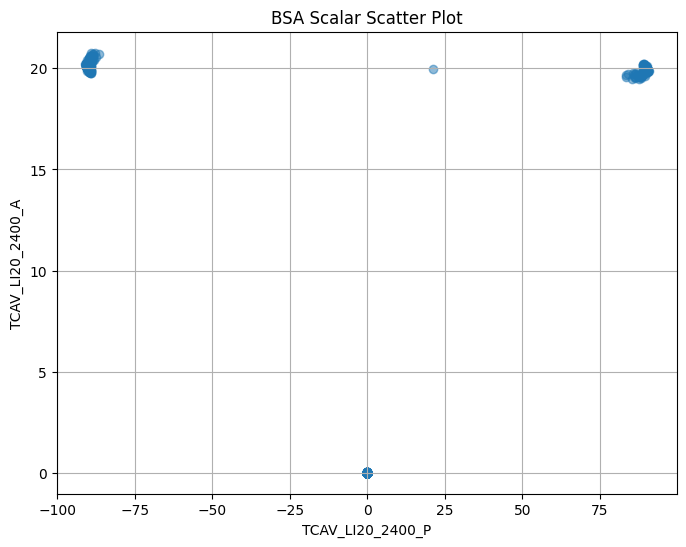

In [15]:
# plot bsaScalarData TCAV_LI20_2400_P and TCAV_LI20_2400_A, most important predictors.
bsaVarNames = bsaVars
var1_name = 'TCAV_LI20_2400_P'
var2_name = 'TCAV_LI20_2400_A'
var1_idx = bsaVarNames.index(var1_name)
var2_idx = bsaVarNames.index(var2_name)
print(f"Plotting BSA Scalars: {var1_name} (index {var1_idx}) and {var2_name} (index {var2_idx})")
plt.figure(figsize=(8,6))
plt.scatter(predictor_tmp[:, var1_idx], predictor_tmp[:, var2_idx], alpha=0.5)
plt.xlabel(var1_name)
plt.ylabel(var2_name)
plt.title('BSA Scalar Scatter Plot')
plt.grid(True)
plt.show()

(554, 110)


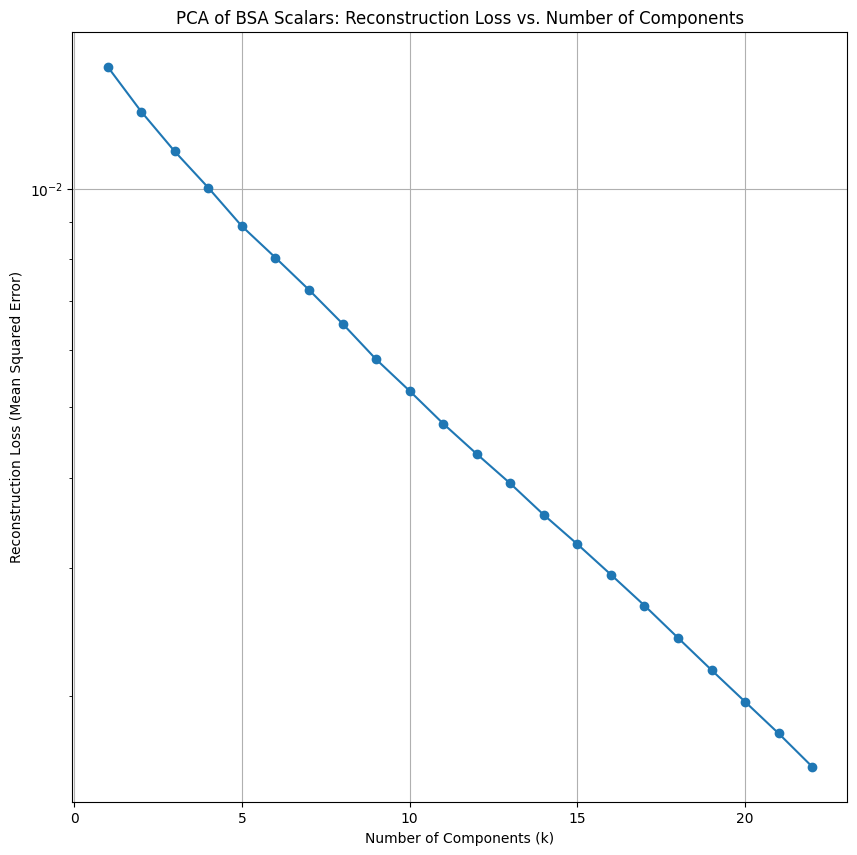

In [16]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming bsaScalarData has shape (N_variables, N_samples) from your function
# Transpose the data so features are columns and samples are rows for scikit-learn PCA
X = predictor_tmp_cleaned
print(X.shape)
bsaVarNames_cleaned = [var for i, var in enumerate(bsaVars) if i not in excluded_var_idx]
# Apply MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Determine the maximum number of components to test
# X.shape is (N_samples, N_variables). max_components = min(N_samples, N_variables) - 1 for a stable PCA
max_components = min(X.shape) // 5 

# Lists to store results
n_components_list = []
reconstruction_losses = []

# Loop through possible number of components
for k in range(1, max_components + 1):
    # 1. Initialize and fit PCA
    pca_study = PCA(n_components=k)
    pca_study.fit(X)
    
    # 2. Transform and Inverse Transform (Reconstruct)
    X_reduced = pca_study.transform(X)
    X_reconstructed = pca_study.inverse_transform(X_reduced)
    
    # 3. Calculate Reconstruction Loss (Mean Squared Error)
    loss = mean_squared_error(X, X_reconstructed)
    
    # Store results
    n_components_list.append(k)
    reconstruction_losses.append(loss)
    
# 4. Plot the Results
plt.figure(figsize=(10, 10))
plt.plot(n_components_list, reconstruction_losses, marker='o', linestyle='-')
plt.xlabel('Number of Components (k)')
plt.ylabel('Reconstruction Loss (Mean Squared Error)')
# Log scale in y-axis for better visualization
plt.yscale('log')
plt.title('PCA of BSA Scalars: Reconstruction Loss vs. Number of Components')
plt.grid(True)
# 5. Identify the "Elbow" point visually after plotting plt.show()
plt.show() 

# After plotting, the optimal number of components is the 'elbow' point.

In [17]:

num_components = 11

pca_comp_study = PCA(n_components=num_components)
X_pca = pca_comp_study.fit_transform(X)
# 1. Get explained variance and component loadings

variance_ratios = pca_comp_study.explained_variance_ratio_
loadings = pca_comp_study.components_

# 2. Create the DataFrame for component composition
# Each row in 'loadings' is a principal component (PC)
# Each column corresponds to a feature (PV)
df_loadings = pd.DataFrame(loadings, columns=bsaVarNames_cleaned)

# 3. Add Component labels and Significance
component_labels = [f'PC {i+1}' for i in range(num_components)]
df_loadings.insert(0, 'Component', component_labels)
df_loadings.insert(1, 'Significance (Explained Variance Ratio)', variance_ratios)

# 4. Format the output
# The components are already ordered by significance (PC 1 is most significant)
# Format the significance column as a percentage for clarity
df_loadings['Significance (Explained Variance Ratio)'] = \
    df_loadings['Significance (Explained Variance Ratio)'].map(lambda x: f'{x:.4f} ({x*100:.2f}%)')

# Format the loadings to a fixed number of decimal places
for col in bsaVarNames_cleaned:
    df_loadings[col] = df_loadings[col].map(lambda x: f'{x:.4f}')

# Display the resulting table
composition_table = df_loadings.to_markdown(index=False)
print("Composition of Principal Components:")
print(composition_table)

Composition of Principal Components:
| Component   | Significance (Explained Variance Ratio)   |   TORO_IN10_431_TMIT |   TORO_IN10_591_TMIT |   TORO_IN10_791_TMIT |   BPMS_IN10_221_X |   BPMS_IN10_221_Y |   BPMS_IN10_221_TMIT |   BPMS_IN10_371_X |   BPMS_IN10_371_Y |   BPMS_IN10_371_TMIT |   BPMS_IN10_425_X |   BPMS_IN10_425_Y |   BPMS_IN10_425_TMIT |   BPMS_IN10_511_X |   BPMS_IN10_511_Y |   BPMS_IN10_511_TMIT |   BPMS_IN10_525_X |   BPMS_IN10_525_Y |   BPMS_IN10_525_TMIT |   BPMS_IN10_581_X |   BPMS_IN10_581_Y |   BPMS_IN10_581_TMIT |   BPMS_IN10_631_X |   BPMS_IN10_631_Y |   BPMS_IN10_631_TMIT |   BPMS_IN10_651_X |   BPMS_IN10_651_Y |   BPMS_IN10_651_TMIT |   BPMS_IN10_731_X |   BPMS_IN10_731_Y |   BPMS_IN10_731_TMIT |   BPMS_IN10_771_X |   BPMS_IN10_771_Y |   BPMS_IN10_771_TMIT |   BLEN_IN10_596_BRAW |   BPMS_IN10_781_X |   BPMS_IN10_781_Y |   BPMS_IN10_781_TMIT |   PMTR_HT10_950_PWR |   LASR_LT10_930_PWR |   KLYS_LI10_21_FB_FAST_PACT |   KLYS_LI10_21_FB_FAST_AACT |   ACCL_LI10_21

In [18]:
# 1. Extract and Square the Loadings (Loadings matrix is: Components x Variables)
# loadings = pca_comp_study.components_ (from your provided code block)
squared_loadings = loadings**2

# 2. Sum Across Components (Sum columns to get total significance per variable)
# The result is an array where each element is the total squared loading for a variable
total_squared_loadings = np.sum(squared_loadings, axis=0)
print(total_squared_loadings.shape)
# 3. Create a DataFrame for sorting
# bsaVars is the list of variable names (features)
df_var_significance = pd.DataFrame({
    'BSA Variable (PV)': bsaVarNames_cleaned,
    'Total Squared Loading (Significance)': total_squared_loadings
})

# 4. Sort in descending order
df_var_significance = df_var_significance.sort_values(
    by='Total Squared Loading (Significance)', 
    ascending=False
).reset_index(drop=True)

# 5. Specify the number of top variables to display
N_top = 20  # Example: display the top few most significant variables

# 6. Format and display the table
df_top_vars = df_var_significance.head(N_top)
df_top_vars['Total Squared Loading (Significance)'] = \
    df_top_vars['Total Squared Loading (Significance)'].map(lambda x: f'{x:.4f}')

inverted_table = df_top_vars.to_markdown(index=False)
print(f"Top {N_top} BSA Variables Ordered by Significance in PCA Components:")
print(inverted_table)


(110,)
Top 20 BSA Variables Ordered by Significance in PCA Components:
| BSA Variable (PV)           |   Total Squared Loading (Significance) |
|:----------------------------|---------------------------------------:|
| BLEN_LI11_359_BRAW          |                                 0.9943 |
| PMT_LI20_3070_QDCRAW        |                                 0.894  |
| LASR_LT10_930_PWR           |                                 0.5957 |
| KLYS_LI10_41_FB_FAST_PACT   |                                 0.4288 |
| PMTR_HT10_950_PWR           |                                 0.3918 |
| ACCL_LI10_21_W0C6_FAST_AACT |                                 0.3777 |
| KLYS_LI10_21_FB_FAST_PACT   |                                 0.3646 |
| KLYS_LI10_41_FB_FAST_AACT   |                                 0.3434 |
| KLYS_LI10_31_FB_FAST_AACT   |                                 0.3063 |
| KLYS_LI10_21_FB_FAST_AACT   |                                 0.299  |
| BPMS_IN10_371_X             |                      

/tmp/ipykernel_2166936/570667637.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_vars['Total Squared Loading (Significance)'] = \


In [19]:

df_filtered = df_var_significance[
    ~df_var_significance['BSA Variable (PV)'].str.contains('BPM', case=False, na=False)
]

# 5. Sort the filtered variables in descending order of significance
df_filtered = df_filtered.sort_values(
    by='Total Squared Loading (Significance)', 
    ascending=False
).reset_index(drop=True)

# 6. Select Top N and format
N_top = 20 # Display the top few most significant non-BPM variables
df_top_vars = df_filtered.head(N_top)

# Format the significance column
df_top_vars['Total Squared Loading (Significance)'] = \
    df_top_vars['Total Squared Loading (Significance)'].map(lambda x: f'{x:.4f}')

# Display the resulting table
inverted_table = df_top_vars.to_markdown(index=False)

print(f"Top {N_top} BSA Variables (EXCLUDING BPMS) Ordered by Significance in PCA Components:")
print(inverted_table)

Top 20 BSA Variables (EXCLUDING BPMS) Ordered by Significance in PCA Components:
| BSA Variable (PV)           |   Total Squared Loading (Significance) |
|:----------------------------|---------------------------------------:|
| BLEN_LI11_359_BRAW          |                                 0.9943 |
| PMT_LI20_3070_QDCRAW        |                                 0.894  |
| LASR_LT10_930_PWR           |                                 0.5957 |
| KLYS_LI10_41_FB_FAST_PACT   |                                 0.4288 |
| PMTR_HT10_950_PWR           |                                 0.3918 |
| ACCL_LI10_21_W0C6_FAST_AACT |                                 0.3777 |
| KLYS_LI10_21_FB_FAST_PACT   |                                 0.3646 |
| KLYS_LI10_41_FB_FAST_AACT   |                                 0.3434 |
| KLYS_LI10_31_FB_FAST_AACT   |                                 0.3063 |
| KLYS_LI10_21_FB_FAST_AACT   |                                 0.299  |
| ACCL_LI10_41_W0C0_FAST_AACT |            

/tmp/ipykernel_2166936/2531780689.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_vars['Total Squared Loading (Significance)'] = \


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from ipywidgets import interact, IntSlider, FloatSlider, Layout
import torch

index_to_examine = 1  # Change this index to examine different test samples

# Variables to be controlled (Non-BPM variables from previous ranking logic)
CONTROL_VARS = [
    'BLEN_LI11_359_BRAW', 
    'LASR_LT10_930_PWR', 'PMTR_HT10_950_PWR', 
    'KLYS_LI10_41_FB_FAST_PACT', 'KLYS_LI10_41_FB_FAST_AACT'
]
# ==============================================================================
# --- DYNAMIC PREDICTION FUNCTION ---
# ==============================================================================
original_predictor_reconstructed = x_scaler.inverse_transform(X_test.numpy())
def plot_dynamic_pred(**slider_values):
    idx = index_to_examine
    fig, (ax1, ax2,ax3, cx1) = plt.subplots(1,4,figsize=(14, 3), gridspec_kw={'width_ratios': [1, 1,1, 0.02]})
    
    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    true_im = biGaussian_image_from_flattened_params(true_params, xrange=xrange, yrange=yrange).T
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(true_im)
        true_im = true_im / pred_im_sum * charge_value
         
    im1 = ax1.imshow(true_im, cmap = "jet",aspect='auto')
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest[idx]})")

    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    pred_im = biGaussian_image_from_flattened_params(pred_params, xrange=xrange, yrange=yrange).T
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(pred_im)
        pred_im = pred_im / pred_im_sum * charge_value
    im2 = ax2.imshow(pred_im, cmap = "jet",aspect='auto')
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")

    # Modify the predictor for the given index based on slider values
    modified_predictor = original_predictor_reconstructed[idx].copy()
    for var_name, slider in slider_values.items():
        pv_index = bsaVarNames_cleaned.index(var_name)
        modified_predictor[pv_index] = slider

    # Scale back the modified predictor
    modified_predictor_scaled = x_scaler.transform(modified_predictor.reshape(1, -1))

    # Make prediction with modified predictor
    modified_predictor_tensor = torch.tensor(modified_predictor_scaled, dtype=torch.float32)
    with torch.no_grad():
        modified_pred_scaled = model.predict(modified_predictor_tensor)
    modified_pred_full = iz_scaler.inverse_transform(modified_pred_scaled)
    modified_pred_params = modified_pred_full[0]
    print(modified_pred_params)
    modified_pred_im = biGaussian_image_from_flattened_params(modified_pred_params, xrange=150, yrange=50).T
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        modified_pred_im_sum = np.sum(modified_pred_im)
        modified_pred_im = modified_pred_im / modified_pred_im_sum * charge_value
    im3 = ax3.imshow(modified_pred_im, cmap = "jet",aspect='auto')
    ax3.set(xlabel = "Time [fs]")
    ax3.set(ylabel = "y [pix]")
    ax3.set(title = "Modified Prediction")

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# ==============================================================================
# --- INTERACTIVE WIDGET SETUP ---
# ==============================================================================

# 1. Calculate min/max for sliders (using the mock raw data)
raw_min_max = {}
for i, pv_name in enumerate(CONTROL_VARS):
    pv_index = bsaVarNames_cleaned.index(pv_name)
    raw_min_max[pv_name] = (predictor_tmp[:, pv_index].min(), predictor_tmp[:, pv_index].max())

N_SAMPLES = Iz_test_true.shape[0]

# 2. Setup the Widgets
widget_kwargs = {}  # Fixed index for demonstration

for i, pv_name in enumerate(CONTROL_VARS):
    min_val, max_val = raw_min_max[pv_name]
    pv_index = bsaVarNames_cleaned.index(pv_name)
    # Initial value is the mean of the range, as we cannot predict 
    # the X_test[idx] value without dynamic input in the slider setup.
    # We set it to 0.0 (or mid-range) and rely on the plot_dynamic_pred 
    # function to construct the input correctly.
    initial_value = original_predictor_reconstructed[index_to_examine, pv_index] # Use the value for the initial index (idx=0)
    
    widget_kwargs[pv_name] = FloatSlider(
        min=min_val, 
        max=max_val, 
        step=(max_val - min_val) / 100.0, # 100 steps granularity
        value=initial_value,
        description=pv_name,
        readout_format='.4f',
        layout=Layout(width='90%')
    )

print("--- Dynamic ML Prediction Explorer ---")
print("Adjust the sliders below to see the real-time effect on the LPS profile prediction.")

# 3. Create the Interactive Interface
# Note: The widget values are passed as keyword arguments to plot_dynamic_pred
interact(plot_dynamic_pred, **widget_kwargs)

--- Dynamic ML Prediction Explorer ---
Adjust the sliders below to see the real-time effect on the LPS profile prediction.


interactive(children=(FloatSlider(value=4811.03125, description='BLEN_LI11_359_BRAW', layout=Layout(width='90%…

<function __main__.plot_dynamic_pred(**slider_values)>

In [ ]:

index_to_examine = 80  # Change this index to examine different test samples

# Variables to be controlled (Non-BPM variables from previous ranking logic)
# ==============================================================================
# --- DYNAMIC PREDICTION FUNCTION ---
# ==============================================================================
original_predictor_reconstructed = x_scaler.inverse_transform(X_test.numpy())
def plot_dynamic_pred(**slider_values):
    idx = index_to_examine
    fig, (ax1, ax2,ax3, cx1) = plt.subplots(1,4,figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1,1, 0.02]})
    
    true_params = Iz_test_true.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    true_im = biGaussian_image_from_flattened_params(true_params, xrange=xrange, yrange=yrange).T
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(true_im)
        true_im = true_im / pred_im_sum * charge_value
         
    im1 = ax1.imshow(true_im, cmap = "jet",aspect='auto')
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest[idx]})")

    pred_params = pred_test_full.T.reshape(NCOMP,Iz_test_true.shape[0])[:,idx]
    pred_im = biGaussian_image_from_flattened_params(pred_params, xrange=xrange, yrange=yrange).T
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        pred_im_sum = np.sum(pred_im)
        pred_im = pred_im / pred_im_sum * charge_value
    im2 = ax2.imshow(pred_im, cmap = "jet",aspect='auto')
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")

    # Modify the predictor for the given index based on slider values
    pca_components = []
    for var_name, slider in slider_values.items():
        # Reconstruct the original predictor values from PCA components
        pca_components.append(slider)
    pca_components = np.array(pca_components).reshape(1, -1)
    modified_predictor = pca_comp_study.inverse_transform(pca_components).flatten()


    # Scale back the modified predictor
    modified_predictor_scaled = modified_predictor.reshape(1, -1)

    # Make prediction with modified predictor
    modified_predictor_tensor = torch.tensor(modified_predictor_scaled, dtype=torch.float32)
    with torch.no_grad():
        modified_pred_scaled = model.predict(modified_predictor_tensor)
    modified_pred_full = iz_scaler.inverse_transform(modified_pred_scaled)
    modified_pred_params = modified_pred_full[0]

    # Print the modified parameters minus the original predicted parameters for comparison
    print("Difference in Parameters from Original Prediction:")
    for i, name in enumerate(["pi_1", "pi_2", "mu_1_x", "mu_1_y", "sigma_1_xx", "sigma_1_xy", "sigma_1_yy", "sigma_2_xx", "sigma_2_xy", "sigma_2_yy"]):
        diff = modified_pred_params[i] - pred_params[i]
        print(f"{name}: {diff:.4f}")

    modified_pred_im = biGaussian_image_from_flattened_params(modified_pred_params, xrange=xrange, yrange=yrange).T
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[valid_rows][ntest[idx]]
        modified_pred_im_sum = np.sum(modified_pred_im)
        modified_pred_im = modified_pred_im / modified_pred_im_sum * charge_value
    im3 = ax3.imshow(modified_pred_im, cmap = "jet",aspect='auto')
    ax3.set(xlabel = "Time [fs]")
    ax3.set(ylabel = "y [pix]")
    ax3.set(title = "Modified Prediction")

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# ==============================================================================
# --- INTERACTIVE WIDGET SETUP ---
# ==============================================================================
# 1. Calculate min/max for sliders (using the mock raw data)

N_SAMPLES = Iz_test_true.shape[0]
pca_vals = pca_comp_study.transform(X_test.numpy())
# 2. Setup the Widgets
widget_kwargs = {}  # Fixed index for demonstration

for i in range(pca_comp_study.components_.shape[0]):
    pv_name = f"PC{i+1}"
    pv_index = i
    min_val, max_val = pca_vals[:, pv_index].min(), pca_vals[:, pv_index].max()
    # Initial value is the mean of the range, as we cannot predict 
    # the X_test[idx] value without dynamic input in the slider setup.
    # We set it to 0.0 (or mid-range) and rely on the plot_dynamic_pred 
    # function to construct the input correctly.
    initial_value = pca_vals[index_to_examine, pv_index] # Use the value for the initial index (idx=0)
    
    widget_kwargs[pv_name] = FloatSlider(
        min=min_val, 
        max=max_val, 
        step=(max_val - min_val) / 100.0, # 100 steps granularity
        value=initial_value,
        description=pv_name,
        readout_format='.4f',
        layout=Layout(width='90%')
    )

print("--- Dynamic ML Prediction Explorer ---")
print("Adjust the sliders below to see the real-time effect on the LPS profile prediction.")

# 3. Create the Interactive Interface
# Note: The widget values are passed as keyword arguments to plot_dynamic_pred
interact(plot_dynamic_pred, **widget_kwargs)

--- Dynamic ML Prediction Explorer ---
Adjust the sliders below to see the real-time effect on the LPS profile prediction.


interactive(children=(FloatSlider(value=0.10907911816622928, description='PC1', layout=Layout(width='90%'), ma…

<function __main__.plot_dynamic_pred(**slider_values)>

### Train on the PCA of variables

In [22]:
# Filter rows with NaN or invalid bi-Gaussian parameters

# --- Original scaling and splitting logic follows ---

predictor_filtered_PCA = pca_comp_study.transform(predictor_filtered)
x_scaler_postPCA = MinMaxScaler()
x_scaled_2 = x_scaler_postPCA.fit_transform(predictor_filtered_PCA)



# 80/20 train-test split
x_train_full_2, x_test_scaled_2, Iz_train_full_2, Iz_test_scaled_2, ntrain_2, ntest_2 = train_test_split(
    x_scaled_2, Iz_scaled, np.arange(Iz_scaled.shape[0]), test_size=0.2, random_state = 42)

# 20% validation split 
x_train_scaled_2, x_validation_2, Iz_train_scaled_2, y_validation_2 = train_test_split(
    x_train_full_2, Iz_train_full_2, test_size=0.2, random_state = 42)

# Convert to PyTorch tensors
X_train_2 = torch.tensor(x_train_scaled_2, dtype=torch.float32)
x_validation_2 = torch.tensor(x_validation_2, dtype=torch.float32)
X_test_2 = torch.tensor(x_test_scaled_2, dtype=torch.float32)
Y_train_2 = torch.tensor(Iz_train_scaled_2, dtype=torch.float32)
y_validation_2 = torch.tensor(y_validation_2, dtype=torch.float32)
Y_test_2 = torch.tensor(Iz_test_scaled_2, dtype=torch.float32)

train_ds = TensorDataset(X_train_2, Y_train_2)
train_dl = DataLoader(train_ds, batch_size=24, shuffle=True)

In [23]:

print(f"X_train shape: {X_train_2.shape}")
print(f"Y_train shape: {Y_train_2.shape}")

# --- 2. Model and Hyperparameter Setup ---
# The Random Forest is initialized with its structure (number of trees, depth, etc.)
# This replaces the PyTorch MLP class definition.

print("\n--- Initializing Model ---")
# Equivalent to: model = MLP(X_train.shape[1], Y_train.shape[1])
# n_estimators is equivalent to the overall model complexity/capacity
# max_depth controls the depth, similar to the number of layers/nodes.
model_postPCA = RandomForestRegressor(
    n_estimators=500,        # Number of trees (like epochs/steps, higher = more complex)
    max_depth=15,            # Max depth of trees (limits complexity)
    min_samples_leaf=5,      # Regularization/pruning parameter
    random_state=42,
    n_jobs=-1                # Use all available cores
)

# Note: In Random Forest, there is no separate 'optimizer' or 'learning rate'
# as the training is done via deterministic tree growing (not gradient descent).


# --- 4. Training and Evaluation (Equivalent to the Training Loop) ---
# Random Forest is trained in a single 'fit' call, not in epochs.
# We mimic the training block structure and calculate loss/metrics.

t0 = time.time()
print("\n--- Starting Model Fitting (One Shot) ---")

# Fit the model (This is the entire 'training loop' for RF)
model_postPCA.fit(X_train_2, Y_train_2)

t1 = time.time()

# --- Evaluation ---

# 1. Training Set Evaluation
Y_train_pred_2 = model_postPCA.predict(X_train_2)
train_mse = mean_squared_error(Y_train_2, Y_train_pred_2)

# 2. Validation Set Evaluation
Y_val_pred_2 = model_postPCA.predict(x_validation_2)
val_mse = mean_squared_error(y_validation_2, Y_val_pred_2)


print("\n--- Training Results ---")
print(f"Total Fitting Time: {t1 - t0:.2f} seconds")
print(f"Final Train MSE: {train_mse:.6f}")
print(f"Final Validation MSE: {val_mse:.6f}")

# To see the importance of the input features:
print("\n--- Feature Importance ---")
for i, importance in enumerate(model_postPCA.feature_importances_):
    print(f"Feature {i} importance: {importance:.4f}")


X_train shape: torch.Size([352, 11])
Y_train shape: torch.Size([352, 10])

--- Initializing Model ---

--- Starting Model Fitting (One Shot) ---

--- Training Results ---
Total Fitting Time: 0.49 seconds
Final Train MSE: 0.006196
Final Validation MSE: 0.010196

--- Feature Importance ---
Feature 0 importance: 0.0456
Feature 1 importance: 0.0435
Feature 2 importance: 0.4246
Feature 3 importance: 0.0620
Feature 4 importance: 0.1059
Feature 5 importance: 0.0424
Feature 6 importance: 0.0325
Feature 7 importance: 0.0549
Feature 8 importance: 0.0213
Feature 9 importance: 0.1437
Feature 10 importance: 0.0236


Elapsed time [mins] = 14.8 
Train R²: 95.59 %
Test R²: 93.84 %


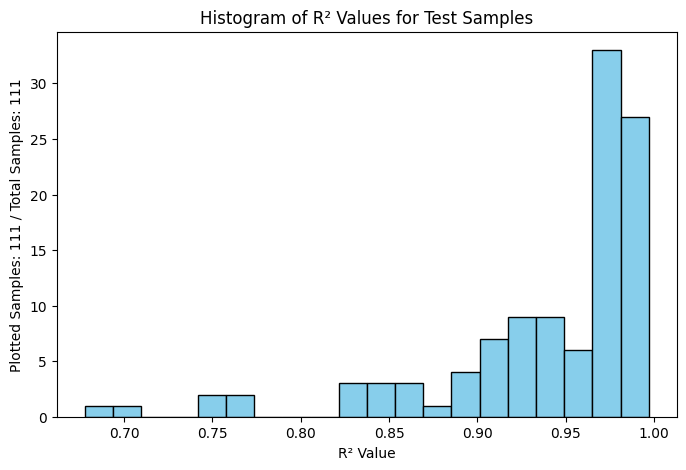

In [36]:
    
# Evaluate model
pred_train_scaled_2 = model_postPCA.predict(X_train_2)
pred_test_scaled_2 = model_postPCA.predict(X_test_2)

# Inverse transform predictions
pred_train_full_2 = iz_scaler.inverse_transform(pred_train_scaled_2)
pred_test_full_2 = iz_scaler.inverse_transform(pred_test_scaled_2)
Iz_train_true_2 = iz_scaler.inverse_transform(Iz_train_scaled_2)
Iz_test_true_2 = iz_scaler.inverse_transform(Iz_test_scaled_2)
elapsed = time.time() - t0
print("Elapsed time [mins] = {:.1f} ".format(elapsed/60))

# Compute R² score
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

# Compute R² on scaled data, instead of the actual bi-Gaussian parameters, to avoid distortion from different scales
print("Train R²: {:.2f} %".format(r2_score(Iz_train_scaled_2.ravel(), pred_train_scaled_2.ravel()) * 100))
print("Test R²: {:.2f} %".format(r2_score(Iz_test_scaled_2.ravel(), pred_test_scaled_2.ravel()) * 100))

# Plot histogram of R² values for each test sample
r2_values = [r2_score(Iz_test_scaled_2.T.reshape(NCOMP,Iz_test_scaled_2.shape[0])[:,i], pred_test_scaled_2.T.reshape(NCOMP,Iz_test_scaled_2.shape[0])[:,i]) for i in range(Iz_test_scaled_2.shape[0])]
# Throw away values outside 0 to 1, and count the number of throws
r2_values_new = [r2 for r2 in r2_values if 0 <= r2 <= 1]
num_throws = len(r2_values) - len(r2_values_new)
plt.figure(figsize=(8, 5))
plt.hist(r2_values_new, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of R² Values for Test Samples')
plt.xlabel('R² Value')
plt.ylabel(f'Plotted Samples: {len(r2_values) - num_throws} / Total Samples: {len(r2_values)}')
plt.show()

In [ ]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image_pred_2(idx):
    FACTOR = 1e15  # to convert s to fs
    fig, (ax0, ax1, ax2, cx1) = plt.subplots(1,4,figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1, 1, 0.02]})

    raw_im = LPSimg[valid_rows][ntest_2[idx]]
    im0 = ax0.imshow(raw_im, cmap = "jet",aspect='auto',extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))
    ax0.set(ylabel="Energy [pix]")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(title = f"Raw Image (Shot Number: {ntest_2[idx]})")


    true_params = Iz_test_true_2.T.reshape(NCOMP,Iz_test_true_2.shape[0])[:,idx]
    true_im = biGaussian_image_from_flattened_params(true_params, total_charge=charge_filtered[ntest_2[idx]], xrange=xrange, yrange=yrange).T
    im1 = ax1.imshow(true_im*FACTOR, cmap = "jet",aspect='auto',extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))

    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="Energy [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest_2[idx]})")
    # print("True Gaussian Parameters:")
    # true_ug = unflatten_biGaussian_params(true_params)
    # print("Means (Mu):", true_ug['mu'].numpy())
    # print("Covariances (Sigma):", true_ug['Sigma'].numpy())
    # print("Weights (Pi):", true_ug['pi'].numpy())


    pred_params = pred_test_full_2.T.reshape(NCOMP,Iz_test_true_2.shape[0])[:,idx]
    pred_im = biGaussian_image_from_flattened_params(pred_params, total_charge=charge_filtered[ntest_2[idx]], xrange=xrange, yrange=yrange).T
    im2 = ax2.imshow(pred_im*FACTOR, cmap = "jet",aspect='auto', extent = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR, 0, 2*yrange))
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "Energy [pix]")
    ax2.set(title = "Prediction")

    print("Predicted Gaussian Parameters:")
    pred_ug = unflatten_biGaussian_params(pred_params)
    print("Means (Mu):", pred_ug['mu'].numpy())
    print("Covariances (Sigma):", pred_ug['Sigma'].numpy())
    print("Weights (Pi):", pred_ug['pi'].numpy())

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    cbar.set_label("Current [A per pixel]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(true_params, pred_params)
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# Create slider
interact(plot_xtcav_image_pred_2, idx=IntSlider(min=0, max=pred_test_full_2.shape[0]-1, step=1, value=0))

(111, 10)


interactive(children=(IntSlider(value=0, description='idx', max=110), Output()), _dom_classes=('widget-interac…

<function __main__.plot_xtcav_image_pred_2(idx)>

### Save Model

In [24]:
raise ImportError("Stop here")

ImportError: Stop here

In [ ]:
import joblib
import pickle
time_stamp = time.strftime("%Y%m%d_%H%M%S")
joblib_file = '../../model/LPS/MLP_LPS_GMM_Forest_'+experiment+'_'+runname+'_'+time_stamp+'.pkl'  
joblib.dump(model, joblib_file)
iz_scaler_file = '../../model/LPS/' + experiment + '_' + runname + '_iz_scaler_GMM_'+time_stamp+'.pkl'
pickle.dump(iz_scaler, open(iz_scaler_file,"wb"))